In [11]:
from rosbags.rosbag2 import Reader
from rosbags.typesys import Stores, get_typestore
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
from cv_bridge import CvBridge

#from zed_interfaces.msg import ObjectsStamped


In [12]:
# Create a typestore and get the string class.
typestore = get_typestore(Stores.ROS2_FOXY)


In [57]:
from pathlib import Path
from rosbags.typesys import Stores, get_types_from_msg, get_typestore

def guess_msgtype(path: Path) -> str:
    """Guess message type name from path."""
    name = path.relative_to(path.parents[2]).with_suffix('')
    if 'msg' not in name.parts:
        name = name.parent / 'msg' / name.name
    return str(name)

typestore = get_typestore(Stores.ROS2_FOXY)  # or Stores.ROS2_FOXY if you're using Foxy

# Paths to the .msg files for ObjectsStamped and its dependent types like Object
msg_paths = [
    '/home/maleen/ros2_ws/install/zed_interfaces/share/zed_interfaces/msg/ObjectsStamped.msg',
    '/home/maleen/ros2_ws/install/zed_interfaces/share/zed_interfaces/msg/Object.msg',  # Add the path for the Object.msg file
    '/home/maleen/ros2_ws/install/zed_interfaces/share/zed_interfaces/msg/BoundingBox2Di.msg',
    '/home/maleen/ros2_ws/install/zed_interfaces/share/zed_interfaces/msg/BoundingBox2Df.msg',
    '/home/maleen/ros2_ws/install/zed_interfaces/share/zed_interfaces/msg/BoundingBox3D.msg',
    '/home/maleen/ros2_ws/install/zed_interfaces/share/zed_interfaces/msg/Keypoint2Di.msg',
    '/home/maleen/ros2_ws/install/zed_interfaces/share/zed_interfaces/msg/Keypoint2Df.msg',
    '/home/maleen/ros2_ws/install/zed_interfaces/share/zed_interfaces/msg/Keypoint3D.msg',
    '/home/maleen/ros2_ws/install/zed_interfaces/share/zed_interfaces/msg/Skeleton2D.msg',
    '/home/maleen/ros2_ws/install/zed_interfaces/share/zed_interfaces/msg/Skeleton3D.msg',
]

add_types = {}

for pathstr in msg_paths:
    msgpath = Path(pathstr)
    msgdef = msgpath.read_text(encoding='utf-8')
    add_types.update(get_types_from_msg(msgdef, guess_msgtype(msgpath)))

# Register the custom types with the typestore
typestore.register(add_types)


In [58]:

# Initialize lists to store data
timestamps = []
skeleton_2d_data = []
skeleton_3d_data = []
image_data =np.array([])

with Reader('/home/maleen/rosbags/Transformers/rosbag2_2024_03_08-16_03_55') as reader:
    for connection, timestamp, rawdata in reader.messages():
        # Handle skeletal data
        if connection.topic == '/zed/zed_node/body_trk/skeletons':
            msg = typestore.deserialize_cdr(rawdata, connection.msgtype)
            for obj in msg.objects:
                if obj.skeleton_available:
                    skeleton_2d_points = [kp.kp.tolist() for kp in obj.skeleton_2d.keypoints]
                    skeleton_3d_points = [kp.kp.tolist() for kp in obj.skeleton_3d.keypoints]

                    timestamps.append(timestamp)
                    skeleton_2d_data.append(skeleton_2d_points)
                    skeleton_3d_data.append(skeleton_3d_points)
                    
        # Handle image data
        elif connection.topic == '/zed/zed_node/rgb_raw/image_raw_color':
            msg = typestore.deserialize_cdr(rawdata, connection.msgtype)
            image_data = np.append(image_data,msg)

# Create a DataFrame
df = pd.DataFrame({
    'Timestamp': timestamps,
    'Skeleton_2D': skeleton_2d_data,
    'Skeleton_3D': skeleton_3d_data,
})

print(df.head())


             Timestamp                                        Skeleton_2D  \
0  1709874236060589165  [[1196.9652099609375, 170.77508544921875], [10...   
1  1709874236109451524  [[1199.13525390625, 171.2069854736328], [1088....   
2  1709874236184780871  [[1202.0823974609375, 170.69488525390625], [10...   
3  1709874236281429824  [[1202.698486328125, 171.0704803466797], [1087...   
4  1709874236314558630  [[1202.8427734375, 171.16123962402344], [1087....   

                                         Skeleton_3D  
0  [[0.4971213638782501, -0.508023738861084, 0.17...  
1  [[0.49629005789756775, -0.5092052817344666, 0....  
2  [[0.4955914616584778, -0.5112428069114685, 0.1...  
3  [[0.49588727951049805, -0.5121241211891174, 0....  
4  [[0.49593672156333923, -0.5123100876808167, 0....  


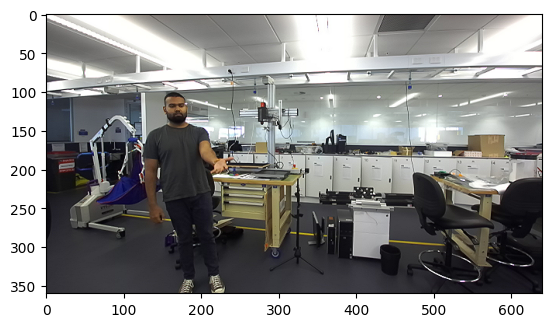

In [59]:
bridge = CvBridge()
detected_images=[]

for img in image_data:
    
    cv_image = bridge.imgmsg_to_cv2(img, desired_encoding="passthrough")
    detected_images.append(cv_image)

#TEST DETECTED IMAGES



plt.imshow(cv2.cvtColor(detected_images[500], cv2.COLOR_BGR2RGB))
#plt.imshow(detected_images[25])
plt.show()

In [60]:

# Original resolution
old_width, old_height = 1280, 720

# New resolution
new_width, new_height = 640, 360

# Calculate scaling factors
scale_x = new_width / old_width
scale_y = new_height / old_height

# Initialize a list to store scaled skeletal data
scaled_skeletal_data = []

# Iterate over each frame/observation
for frame in skeleton_2d_data:
    # Scale each point in the frame
    scaled_frame = [[x * scale_x, y * scale_y] if x > 0 and y > 0 else [x, y] for x, y in frame]
    scaled_skeletal_data.append(scaled_frame)

# Convert the list back to a NumPy array if needed
scaled_skeletal_data = np.array(scaled_skeletal_data, dtype=np.float32)

# Now, scaled_skeletal_data contains the scaled skeletal points for each frame/observation


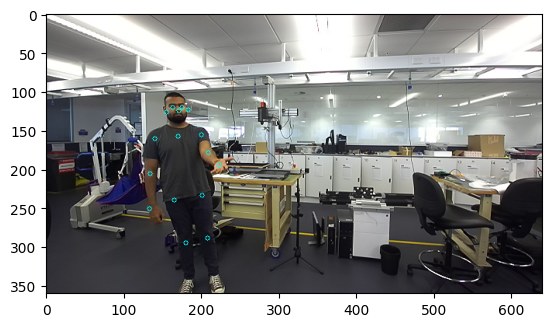

In [62]:
test_img=detected_images[500]

for point in scaled_skeletal_data[500]:
    x, y = int(point[0]), int(point[1])
    #print(x)
    cv2.circle(test_img, (x, y), radius=3, color=(255, 255, 0), thickness=1)  # Draw a green circle at each point
    
plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))
#plt.imshow(detected_images[25])
plt.show()

In [22]:
df.shape

(923, 3)

In [25]:
len(detected_images)

924